# Natural Language Processing
One of my objectives was to predict from the description how well the movie was going to be received.
To do that I need to work with the ``description`` column as input, and change the ``rating`` column into a boolean one where True is over 5 of valoration.

In [1]:
import pandas as pd
import numpy as np

In [20]:
data = pd.read_csv('data\imdb_processed.csv')

In [21]:
sample = data.sample(100, random_state=42)

## Target column

In [22]:
def approved(rating):
    if rating >= 5.0:
        return True
    else:
        return False

In [23]:
data['rating_bool'] = data.rating.map(approved)
data['rating_bool'].value_counts()

True     34685
False     5101
Name: rating_bool, dtype: int64

The target is very unbalanced, and I also need to reduce the amount of rows in me dataset due to time constraints, so I will apply some downsampling.

In [24]:
from sklearn.utils import resample

In [25]:
category_0 = data[data['rating_bool'] == False]
print(category_0.shape)
category_1 = data[data['rating_bool'] == True]
print(category_1.shape)

(5101, 12)
(34685, 12)


In [26]:
category_1_undersampled = resample(category_1, 
                                   replace=False, 
                                   n_samples = len(category_0))

In [27]:
print(category_1_undersampled.shape)

(5101, 12)


In [28]:
data_downsampled = pd.concat([category_0, category_1_undersampled], axis=0)

In [29]:
data_downsampled.shape

(10202, 12)

## Processing text

In [30]:
# text = data[['genres', 'description']]
descriptions = data_downsampled.description


In [7]:
from nltk.tokenize import word_tokenize
import nltk
# nltk.download('punkt')

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet

from nltk.corpus import stopwords

import re



In [32]:
def clean_up(s):
    """
    Cleans up numbers, URLs, and special characters from a string.

    Args:
        s: The string to be cleaned up.

    Returns:
        A string that has been cleaned up.
    """
    reg_url = '(?:(?:https?|ftp):\/\/)?[\w\/\-?=%.]+\.[\w\/\-&?=%.]+'
    reg_sp  = '[^A-Za-z ]'

    s = re.sub(reg_url,'',s) 

    s = re.sub(reg_sp,' ',s) 

    return s

def tokenize(s):
    """
    Tokenize a string.

    Args:
        s: String to be tokenized.

    Returns:
        A list of words as the result of tokenization.
    """
    s = word_tokenize(s)

    return s

def stem_and_lemmatize(l):
    """
    Perform stemming and lemmatization on a list of words.

    Args:
        l: A list of strings.

    Returns:
        A list of strings after being stemmed and lemmatized.
    """
    ps = PorterStemmer() #I'm not convinced these go here
    lemmatizer = WordNetLemmatizer() 

    list = [lemmatizer.lemmatize(ps.stem(word)) for word in l]

    for word in l:
        word = ps.stem(word)
        word = lemmatizer.lemmatize(word)

    return list

def remove_stopwords(l):
    """
    Remove English stopwords from a list of strings.

    Args:
        l: A list of strings.

    Returns:
        A list of strings after stop words are removed.
    """
    clean_list = [word for word in l if not word in stopwords.words()]

    return clean_list

def full_process(s):
    '''
    Args:
        s: the string to process

    Returns:
        The list of words after removing the stopwords
    '''
    s = clean_up(s)
    l = tokenize(s)
    l = stem_and_lemmatize(l)
    clean_list = remove_stopwords(l)

    return clean_list

In [33]:
data_downsampled['tokens'] = descriptions.apply(full_process) #full
data_downsampled['tokens'][:15]

5      [guest, hous, stockholm, group, music, student...
9      [waitress, inga, pregnant, father, sailor, edv...
10     [john, ulla, happili, marri, live, villa, frid...
27     [tex, robbin, texa, ranger, pose, wolf, cassid...
40     [sensat, court, poverti, row, entri, town, vam...
47     [origin, titl, trail, killer, qv, misnom, wa, ...
122    [lisa, young, woman, live, countrysid, go, sto...
137    [gangster, get, boxer, throw, import, fight, f...
146                  [g, unemploy, join, gang, smuggler]
176    [timid, wynn, thrust, spotlight, hi, father, h...
182    [canadian, mounti, assign, bring, hi, brother,...
185    [kelli, daughter, fall, revenu, agent, hi, div...
195    [tad, wallac, act, flop, broadway, join, troop...
258    [pilot, hi, crash, land, island, run, psycho, ...
269    [sham, ceremoni, hall, dimwit, fridolf, marri,...
Name: tokens, dtype: object

In [34]:
data_downsampled

,tconst,primaryTitle,isAdult,startYear,runtimeMinutes,rating,genres,mpaa,description,votes,year_process,rating_bool,tokens
5,tt0023534,En stulen vals,0,1932,83,3.9,['drama'],Not Rated,['A guest house in Stockholm. A group of music...,9.0,1932,False,"[guest, hous, stockholm, group, music, student..."
9,tt0023541,Svarta rosor,0,1932,86,4.8,['drama'],Not Rated,['The waitress Inga is pregnant and the father...,9.0,1932,False,"[waitress, inga, pregnant, father, sailor, edv..."
10,tt0023542,Svärmor kommer,0,1932,84,3.8,['comedy'],Not Rated,['John and Ulla are happily married and live i...,8.0,1932,False,"[john, ulla, happili, marri, live, villa, frid..."
27,tt0023570,The Texas Tornado,0,1932,53,4.7,['western'],Approved,"['Tex Robbins, a Texas Ranger, posing as ""Wolf...",25.0,1932,False,"[tex, robbin, texa, ranger, pose, wolf, cassid..."
40,tt0023592,Thrill of Youth,0,1932,60,3.9,['drama'],Not Rated,['A sensation-courting poverty-row entry in wh...,24.0,1932,False,"[sensat, court, poverti, row, entri, town, vam..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14646,tt0049476,Man in the Vault,0,1956,73,6.0,"['crime', 'drama', 'film-noir']",Approved,['A locksmith gets caught up in a bank robbery...,417.0,1956,True,"[locksmith, get, caught, bank, robberi, angel,..."
28517,tt0796926,Cheese Head,0,2006,90,6.0,"['comedy', 'drama']",Not Rated,['Year 1993. Ariel and his family spend their ...,502.0,2006,True,"[year, ariel, hi, famili, spend, summer, idyl,..."
14956,tt0049970,Yaqui Drums,0,1956,71,5.9,['western'],Not Rated,"[""After his brother's mysterious murder, Webb ...",22.0,1956,True,"[hi, brother, mysteri, murder, webb, dunham, h..."
9210,tt0040087,All My Sons,0,1948,94,7.4,"['drama', 'film-noir']",Approved,"[""During WW2, industrialist Joe Keller commits...",1978.0,1948,True,"[dure, ww, industrialist, joe, keller, commit,..."


In [16]:
# data_downsampled.to_csv('data\data_downsampled.csv', index=False)

In [17]:
data_downsampled = pd.read_csv('data\data_downsampled.csv')

## Word list
Is a distribution of frequencies for the words.

In [80]:
from nltk.probability import FreqDist

In [81]:
token_list = data_downsampled['tokens'].tolist()

In [82]:
word_list = []
regx  = '''[\[\]\"\']'''


for token in token_list:
    # word_list = word_list + list(token_list[i])
    token = re.sub(regx,'',token)
    list = token.split(', ')
    word_list = word_list + list

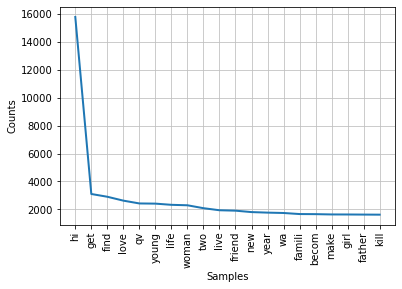

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [100]:
fd = FreqDist(word_list)

fd.plot(20, cumulative=False)

I can already see a big outlier with the word ' hi', I will have to treat it.


In [101]:
fd.max()

'hi'

In [102]:
word_list2 = word_list

I will use a list comprehension to read the original ``word_list`` and copy everything that is not 'hi' to a new list.

In [103]:
def remove_values_from_list(the_list, val):
   return [value for value in the_list if value != val]


word_list2 = remove_values_from_list(word_list, 'hi')
fd = FreqDist(word_list2)
fd.max()

'get'

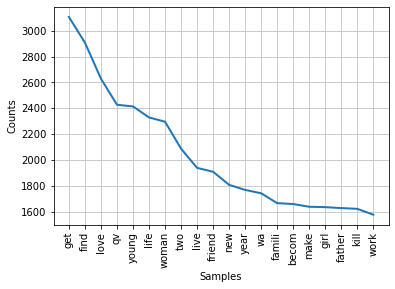

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [104]:
fd.plot(20, cumulative=False)

Now this plot looks much better.

In [105]:
len(fd)

32032

That is a high amount of words, but I can select just the most common:

In [106]:
most_common = fd.most_common(500)

In [107]:
common_word_list = [a_tuple[0] for a_tuple in most_common]
# common_word_list

In [108]:
def find_features(row):
    words = row['tokens']
    features = {}
    for w in common_word_list:
        features[w] = (w in words)

        

    return (features, row['rating_bool'])

In [109]:
features = data_downsampled.apply(find_features, axis=1).tolist()

In [110]:
len(features)

10202

With my features done, I can use a Naive Bayes Model to try to predict whether the movie has a score above 5 or not.  
1st -> Train/Test split

In [111]:
frontier = int(np.ceil(len(features)*0.8))

# set that we'll train our classifier with
training_set = features[:frontier]

# set that we'll test against.
testing_set = features[frontier:]

2nd -> Training

In [112]:
classifier = nltk.NaiveBayesClassifier.train(training_set)


3rd -> Testing

In [113]:
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)


Classifier accuracy percent: 41.96078431372549


In [114]:
classifier.show_most_informative_features(15)

Most Informative Features
                   huggo = True             True : False  =      6.8 : 1.0
                  despit = True             True : False  =      4.0 : 1.0
             documentari = True             True : False  =      3.2 : 1.0
                 rancher = True             True : False  =      2.9 : 1.0
                   alien = True            False : True   =      2.6 : 1.0
               scientist = True            False : True   =      2.6 : 1.0
                  brazil = True             True : False  =      2.6 : 1.0
                 claudio = True             True : False  =      2.6 : 1.0
                  romanc = True             True : False  =      2.6 : 1.0
                  second = True             True : False  =      2.5 : 1.0
                carvalho = True             True : False  =      2.5 : 1.0
                 janeiro = True             True : False  =      2.4 : 1.0
                    pari = True             True : False  =      2.4 : 1.0

The accuracy does not seem that good, I'll try using more words:

In [115]:
most_common = fd.most_common(3000)
common_word_list = [a_tuple[0] for a_tuple in most_common]
features = data_downsampled.apply(find_features, axis=1).tolist()

frontier = int(np.ceil(len(features)*0.8))
training_set = features[:frontier]
testing_set = features[frontier:]

classifier = nltk.NaiveBayesClassifier.train(training_set)

print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)

Classifier accuracy percent: 44.509803921568626


Adding more words doesn't seem to help that much. Now I will try running the model with the word I removed before, 'hi'.

In [142]:
word_list = []
regx  = '''[\[\]\"\']'''


for token in token_list:
    # word_list = word_list + list(token_list[i])
    token = re.sub(regx,'',token)
    list = token.split(', ')
    word_list = word_list + list

In [144]:
fd2 = FreqDist(word_list)

del most_common

most_common = fd2.most_common(3000)
common_word_list = [a_tuple[0] for a_tuple in most_common]

features = data_downsampled.apply(find_features, axis=1).tolist()

frontier = int(np.ceil(len(features)*0.8))

# set that we'll train our classifier with
training_set = features[:frontier]

# set that we'll test against.
testing_set = features[frontier:]

classifier = nltk.NaiveBayesClassifier.train(training_set)

print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)

Classifier accuracy percent: 44.509803921568626


It is a bit suspicious to get the exact same accuracies with 'hi' and 500 words and without 'hi' and 3000 words, but I cannot find the reason so far.

I want to study further on what is happening here, so I will add the features to the dataframe so I can see what the descriptions with 'hi' in it have in common.

In [147]:
def find_features_column(row):
    words = row['tokens']
    features = {}
    for w in common_word_list:
        features[w] = (w in words)

    return features

In [148]:
words_df = data_downsampled.apply(find_features_column, axis=1)

In [149]:
words_df

0        {'hi': False, 'get': False, 'find': False, 'lo...
1        {'hi': True, 'get': False, 'find': True, 'love...
2        {'hi': True, 'get': True, 'find': False, 'love...
3        {'hi': True, 'get': True, 'find': False, 'love...
4        {'hi': False, 'get': False, 'find': False, 'lo...
                               ...                        
10197    {'hi': True, 'get': True, 'find': False, 'love...
10198    {'hi': True, 'get': False, 'find': False, 'lov...
10199    {'hi': True, 'get': True, 'find': False, 'love...
10200    {'hi': True, 'get': False, 'find': False, 'lov...
10201    {'hi': True, 'get': True, 'find': True, 'love'...
Length: 10202, dtype: object

In [151]:
type(words_df)

pandas.core.series.Series

In [154]:
new_df = pd.DataFrame(words_df.tolist())

In [155]:
new_df

,hi,get,find,love,qv,young,life,woman,two,live,...,sensit,nudist,venic,compromis,sunni,joke,elabor,multipl,intellectu,grip
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,True,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10197,True,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
10198,True,False,False,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10199,True,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10200,True,False,False,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [156]:
data_downsampled.reset_index(drop=True)

,tconst,primaryTitle,isAdult,startYear,runtimeMinutes,rating,genres,mpaa,description,votes,year_process,rating_bool,tokens
0,tt0023534,En stulen vals,0,1932,83,3.9,['drama'],Not Rated,['A guest house in Stockholm. A group of music...,9.0,1932,False,"['guest', 'hous', 'stockholm', 'group', 'music..."
1,tt0023541,Svarta rosor,0,1932,86,4.8,['drama'],Not Rated,['The waitress Inga is pregnant and the father...,9.0,1932,False,"['waitress', 'inga', 'pregnant', 'father', 'sa..."
2,tt0023542,Svärmor kommer,0,1932,84,3.8,['comedy'],Not Rated,['John and Ulla are happily married and live i...,8.0,1932,False,"['john', 'ulla', 'happili', 'marri', 'live', '..."
3,tt0023570,The Texas Tornado,0,1932,53,4.7,['western'],Approved,"['Tex Robbins, a Texas Ranger, posing as ""Wolf...",25.0,1932,False,"['tex', 'robbin', 'texa', 'ranger', 'pose', 'w..."
4,tt0023592,Thrill of Youth,0,1932,60,3.9,['drama'],Not Rated,['A sensation-courting poverty-row entry in wh...,24.0,1932,False,"['sensat', 'court', 'poverti', 'row', 'entri',..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10197,tt0049476,Man in the Vault,0,1956,73,6.0,"['crime', 'drama', 'film-noir']",Approved,['A locksmith gets caught up in a bank robbery...,417.0,1956,True,"['locksmith', 'get', 'caught', 'bank', 'robber..."
10198,tt0796926,Cheese Head,0,2006,90,6.0,"['comedy', 'drama']",Not Rated,['Year 1993. Ariel and his family spend their ...,502.0,2006,True,"['year', 'ariel', 'hi', 'famili', 'spend', 'su..."
10199,tt0049970,Yaqui Drums,0,1956,71,5.9,['western'],Not Rated,"[""After his brother's mysterious murder, Webb ...",22.0,1956,True,"['hi', 'brother', 'mysteri', 'murder', 'webb',..."
10200,tt0040087,All My Sons,0,1948,94,7.4,"['drama', 'film-noir']",Approved,"[""During WW2, industrialist Joe Keller commits...",1978.0,1948,True,"['dure', 'ww', 'industrialist', 'joe', 'keller..."


In [165]:
data_downsampled_2 = pd.concat([data_downsampled, new_df], axis=1)
pd.set_option('display.max_colwidth', None)
data_downsampled_2['description'].loc[data_downsampled_2.hi == True].head(5)

1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

The 'hi' in question is what I got from stemming/lemmatizing the words 'him' or 'his'.

The next part would be to apply this dataset to linear and logistic regressions.

In [166]:
data_downsampled_2.to_csv('data\data_tokenized.csv', index=False)